# Initialization

Import packages and setup

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest, f_classif, r_regression, chi2
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier

import cdt
cdt.SETTINGS.rpath = r'C:\Program Files\R\R-4.2.2\bin\Rscript'
from cdt.causality.graph import GES

import warnings
warnings.filterwarnings('ignore')

# Set the random seed for reproducibility
seed = 0
np.random.seed(seed)

C:\Users\prata\miniconda3\envs\default\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


Load dataset

In [2]:
def load_data(url):
    df = pd.read_csv(url, index_col=0)
    X = df.loc[:, df.columns != 'Churn Value']
    y = df.loc[:, df.columns == 'Churn Value']
    return df, X, y

df_train, X_train, y_train = load_data('https://raw.githubusercontent.com/prat-man/CSE-572-Data-Mining/main/data/train_data.csv')
df_val, X_val, y_val = load_data('https://raw.githubusercontent.com/prat-man/CSE-572-Data-Mining/main/data/val_data.csv')
df_test, X_test, y_test = load_data('https://raw.githubusercontent.com/prat-man/CSE-572-Data-Mining/main/data/test_data.csv')

# Causal Discovery

Define features and outcomes

In [3]:
features = X_train.columns.tolist()
outcomes = y_train.columns.tolist()

Discover causal structures

In [4]:
model = GES()
skeleton = nx.Graph(df_train.cov())
model_graph = model.predict(df_train, skeleton)

Detect relevant nodes and edges

In [5]:
relevant_features = set()
relevant_nodes = set()
relevant_edges = set()

for feature in features:
    for outcome in outcomes:
        if model_graph.has_edge(feature, outcome):
            relevant_features.add(feature)
            relevant_nodes.add(feature)
            relevant_nodes.add(outcome)
            relevant_edges.add((feature, outcome))

for feature in sorted(relevant_features):
    print(feature)

Contract_Month-to-month
Dependents_Yes
Streaming Movies_No internet service
Streaming Movies_Yes
Tech Support_Yes
Tenure Months


Draw the causal graph

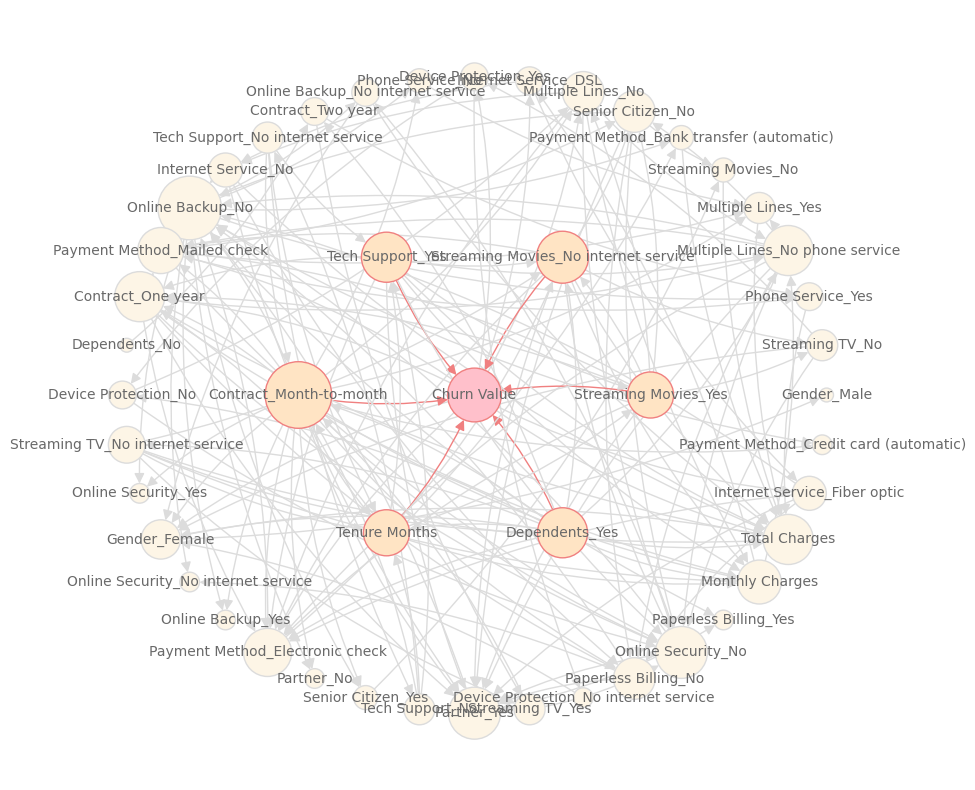

In [6]:
fig = plt.figure(figsize=(10, 8))
for i in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[i].set_visible(False)

degrees = model_graph.degree()
node_colors = ['pink' if node in outcomes else 'bisque' if node in relevant_features else 'oldlace' for node in model_graph.nodes]
node_sizes = [max(v, 1) * 100 for k, v in degrees]
node_edge_colors = ['lightcoral' if node in relevant_nodes else 'gainsboro' for node in model_graph.nodes]
edge_colors = ['lightcoral' if edge in relevant_edges else 'gainsboro' for edge in model_graph.edges]
pos = nx.shell_layout(model_graph, [outcomes, relevant_features, list(set(features) - set(relevant_features))])

nx.draw_networkx(model_graph,
                 pos=pos,
                 connectionstyle="arc3,rad=0.1",
                 node_color=node_colors,
                 node_size=node_sizes,
                 edgecolors=node_edge_colors,
                 edge_color=edge_colors,
                 font_size=10,
                 font_color='dimgray',
                 arrowsize=15,
                 clip_on=False)

plt.tight_layout()
plt.show()
# plt.savefig('graph.png', dpi=300)

# Evaluation

In [7]:
def evaluate(clf, x, y):
    y_pred = clf.predict(x)
    print(f'Overall accuracy: {accuracy_score(y, y_pred)}\n')
    print(classification_report(y, y_pred, zero_division=0))

## All Features

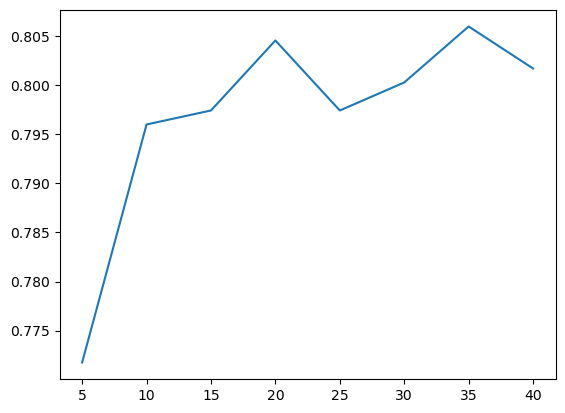

In [8]:
accuracy = []
x_axis = range(5, 41, 5)

for i in x_axis:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_val)
    accuracy.append(accuracy_score(y_val, y_pred))

plt.xticks(x_axis)
plt.plot(x_axis, accuracy)

In [9]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)
evaluate(knn, X_test, y_test)

Overall accuracy: 0.8005698005698005

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       534
           1       0.58      0.61      0.60       168

    accuracy                           0.80       702
   macro avg       0.73      0.74      0.73       702
weighted avg       0.80      0.80      0.80       702



## Causality Based Features

In [10]:
X_train_causal = X_train[list(relevant_features)]
X_val_causal = X_val[list(relevant_features)]
X_test_causal = X_test[list(relevant_features)]

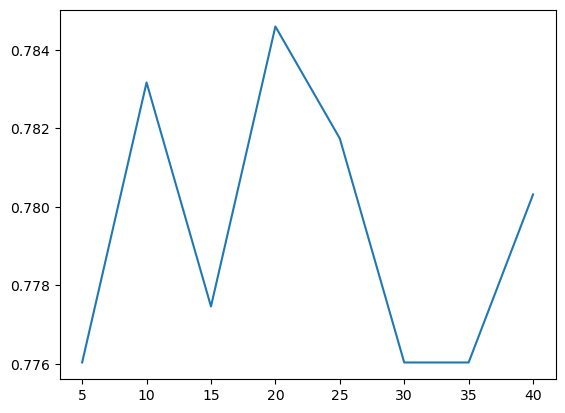

In [11]:
accuracy = []
x_axis = range(5, 41, 5)

for i in x_axis:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_causal, y_train)
    y_pred = knn.predict(X_val_causal)
    accuracy.append(accuracy_score(y_val, y_pred))

plt.xticks(x_axis)
plt.plot(x_axis, accuracy)

In [12]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train_causal, y_train)
evaluate(knn, X_test_causal, y_test)

Overall accuracy: 0.7948717948717948

              precision    recall  f1-score   support

           0       0.86      0.87      0.87       534
           1       0.57      0.56      0.57       168

    accuracy                           0.79       702
   macro avg       0.72      0.71      0.72       702
weighted avg       0.79      0.79      0.79       702



## ANOVA

In [13]:
anova = SelectKBest(f_classif, k=6).fit(X_train, y_train)

anova_features = X_train.iloc[:, np.argsort(anova.scores_)[:6]].columns.values

for feature in sorted(anova_features):
    print(feature)

Gender_Female
Gender_Male
Multiple Lines_No
Multiple Lines_No phone service
Phone Service_No
Phone Service_Yes


In [14]:
X_train_anova = anova.transform(X_train)
X_val_anova = anova.transform(X_val)
X_test_anova = anova.transform(X_test)

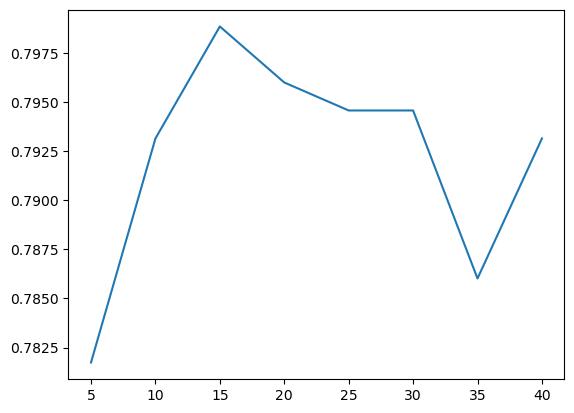

In [15]:
accuracy = []
x_axis = range(5, 41, 5)

for i in x_axis:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_anova, y_train)
    y_pred = knn.predict(X_val_anova)
    accuracy.append(accuracy_score(y_val, y_pred))

plt.xticks(x_axis)
plt.plot(x_axis, accuracy)

In [16]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train_anova, y_train)
evaluate(knn, X_test_anova, y_test)

Overall accuracy: 0.7934472934472935

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       534
           1       0.58      0.48      0.53       168

    accuracy                           0.79       702
   macro avg       0.71      0.69      0.70       702
weighted avg       0.78      0.79      0.79       702



## Pearson

In [17]:
pearson = SelectKBest(r_regression, k=6).fit(X_train, y_train)

pearson_features = X_train.iloc[:, np.argsort(pearson.scores_)[:6]].columns.values

for feature in sorted(pearson_features):
    print(feature)

Contract_Two year
Dependents_Yes
Device Protection_No internet service
Online Backup_No internet service
Tech Support_No internet service
Tenure Months


In [18]:
X_train_pearson = pearson.transform(X_train)
X_val_pearson = pearson.transform(X_val)
X_test_pearson = pearson.transform(X_test)

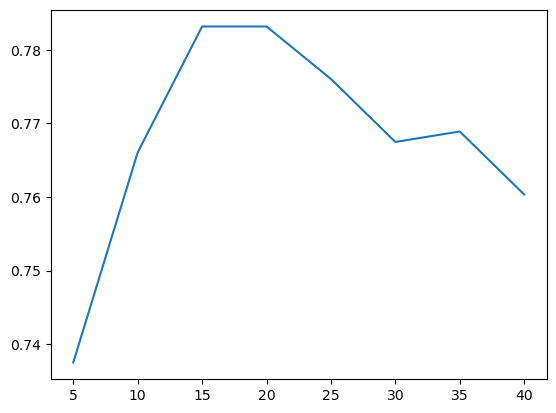

In [19]:
accuracy = []
x_axis = range(5, 41, 5)

for i in x_axis:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_pearson, y_train)
    y_pred = knn.predict(X_val_pearson)
    accuracy.append(accuracy_score(y_val, y_pred))

plt.xticks(x_axis)
plt.plot(x_axis, accuracy)

In [20]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train_pearson, y_train)
evaluate(knn, X_test_pearson, y_test)

Overall accuracy: 0.7962962962962963

              precision    recall  f1-score   support

           0       0.86      0.87      0.87       534
           1       0.58      0.56      0.57       168

    accuracy                           0.80       702
   macro avg       0.72      0.72      0.72       702
weighted avg       0.79      0.80      0.80       702



## PCA

In [21]:
pca = PCA(n_components=6).fit(X_train)

X_train_pca = pca.transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

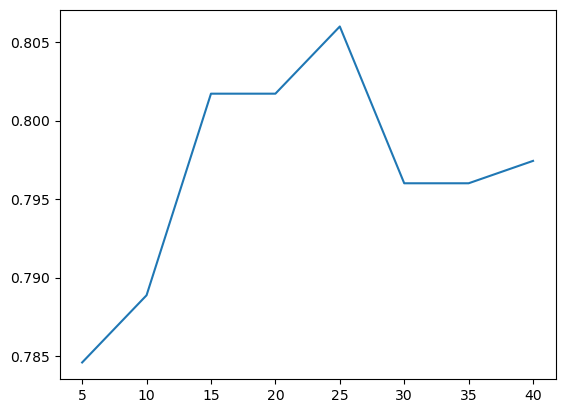

In [22]:
accuracy = []
x_axis = range(5, 41, 5)

for i in x_axis:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_pca, y_train)
    y_pred = knn.predict(X_val_pca)
    accuracy.append(accuracy_score(y_val, y_pred))

plt.xticks(x_axis)
plt.plot(x_axis, accuracy)

In [23]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train_pca, y_train)
evaluate(knn, X_test_pca, y_test)

Overall accuracy: 0.8062678062678063

              precision    recall  f1-score   support

           0       0.86      0.89      0.87       534
           1       0.61      0.54      0.57       168

    accuracy                           0.81       702
   macro avg       0.73      0.72      0.72       702
weighted avg       0.80      0.81      0.80       702

